## Assignment 4 Monte Carlo
# By Dima Mohsin

Starting with importing important packages. 
Reaction rate values are in a dictionary called parameters. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import time

For question 1 a I have defined propensities as prop including X and my coefficients. Prop returns all 18 reactions for the reaction.   stochastic as stoch matrix. I also have my parameters as a dictionary with all reaction rates. 

In [6]:
#Reaction rates values definition in h^-1
parameters = {
    'Transcription_rates': {
        'alpha_A': 50,
        'alpha_prime_A': 500, 
        'alpha_R': 0.01,
        'alpha_prime_R': 50
    },
    'Degradation_rates': {
        'delta_MA': 10,
        'delta_MR': 0.5, 
        'delta_A': 1, 
        'delta_R': 0.2
    },
    'Binding_rates': {
        'gamma_A': 1,  # mol^-1 h^-1
        'gamma_R': 1,  # mol^-1 h^-1
        'gamma_C': 2   # mol^-1 h^-1
    },
    'Unbinding_rates': {
        'theta_A': 50, 
        'theta_R': 100
    },
    'Translation_rates': {
        'beta_A': 50, 
        'beta_R': 5
    }
}

alpha_A = parameters['Transcription_rates']['alpha_A']  
alpha_R = parameters['Transcription_rates']['alpha_R']
alpha_prime_A = parameters['Transcription_rates']['alpha_prime_A']
alpha_prime_R = parameters['Transcription_rates']['alpha_prime_R']
    
delta_MA = parameters['Degradation_rates']['delta_MA']    
delta_MR = parameters['Degradation_rates']['delta_MR']
delta_A = parameters['Degradation_rates']['delta_A']
delta_R = parameters['Degradation_rates']['delta_R']

gamma_A = parameters['Binding_rates']['gamma_A']
gamma_R = parameters['Binding_rates']['gamma_R']
gamma_C = parameters['Binding_rates']['gamma_C']

theta_A = parameters['Unbinding_rates']['theta_A']
theta_R = parameters['Unbinding_rates']['theta_R']

beta_A = parameters['Translation_rates']['beta_A']
beta_R = parameters['Translation_rates']['beta_R']


In [7]:
def prop(X,coeff):
    DA,D_prime_A, DR, D_prime_R, A, R, MA, MR, C = X
    theta_A, gamma_A, theta_R, gamma_R, delta_MA, delta_A, gamma_C, delta_MR, delta_R, alpha_prime_A, alpha_A, beta_A, alpha_prime_R, alpha_R, beta_R = coeff
    return [theta_A*D_prime_A, 
    gamma_A*DA*A, 
    theta_R*D_prime_R, 
    gamma_R*DR*A, 
    delta_MA*MA, 
    delta_A*A, 
    gamma_C*A*R,
    delta_MR*MR, 
    delta_R*R, 
    delta_A*C,
    alpha_prime_A*D_prime_A,
    alpha_A*DA,
    beta_A*MA,
    theta_A*D_prime_A, 
    theta_R*D_prime_R, 
    alpha_prime_R*D_prime_R,
    alpha_R*DR,
    beta_R*MR]
    
def stoch(): return np.array([[1,-1,0,0,0,0,0,0,0], #1
                      [-1,1,0,0,-1,0,0,0,0], #2
                      [0,0,1,-1,0,0,0,0,0], #3
                      [0,0,-1,1,-1,0,0,0,0], #4
                      [0,0,0,0,0,0,-1,0,0], #5
                      [0,0,0,0,-1,0,0,0,0], #6
                      [0,0,0,0,-1,-1,0,0,1], #7
                      [0,0,0,0,0,0,0,-1,0], #8
                      [0,0,0,0,0,-1,0,0,0], #9
                      [0,0,0,0,0,1,0,0,-1], #10
                      [0,0,0,0,0,0,1,0,0], #11
                      [0,0,0,0,0,0,1,0,0], #12
                      [0,0,0,0,1,0,0,0,0], #13
                      [0,0,0,0,1,0,0,0,0],  #14
                      [0,0,0,0,1,0,0,0,0], #15
                      [0,0,0,0,0,0,0,1,0], #16
                      [0,0,0,0,0,0,0,1,0], #17
                      [0,0,0,0,0,1,0,0,0]]) #18

    
coeff = [theta_A, gamma_A, theta_R, gamma_R, delta_MA, delta_A, gamma_C, delta_MR, delta_R, alpha_prime_A, alpha_A, beta_A, alpha_prime_R, alpha_R, beta_R]
coeff = np.array([50, 1, 100, 1, 10, 1, 2, 0.5, 0.2, 500, 50, 50, 50, 0.01, 5])


#Time intervall
tspan = [0, 400]  # Time interval duration

# Initial condition values
X0 = np.array([1,0,1,0,0,0,0,0,0])  


The time it took for the stochastic plot c  is 51.38789200782776s


Text(0, 0.5, 'Number of molecules (A)')

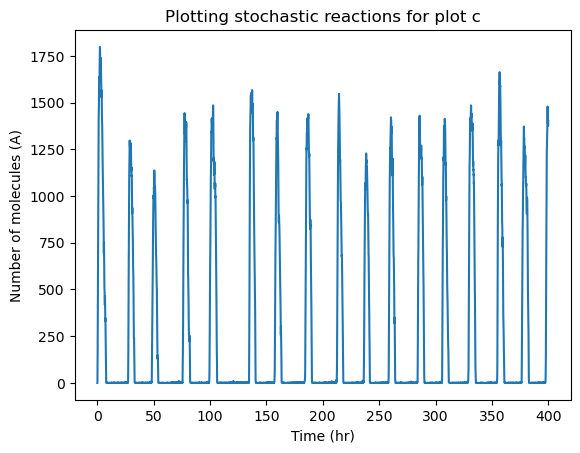

In [8]:
#==============================================
# Gillespies algorithm, SSA
# Version 2, much quicker then previous version
#==============================================
import numpy as np

def SSA(prop, stoch, X0, tspan, coeff, step=0.02):
    # prop  - A function defining the propensities. The calling signature is
    #         prop(X,coeff), and it returns 1D-array or list.
    # stoch - Stoichiometry matrix. 2D-matrix, columns corresponding to the states
    #         and the rows correspond to the equations.
    # X0    - Initial values. A 1D-array or a list.
    # tspan - Time interval (list)
    # coeff - Extra parameters. 1D-array or list
    # step  - Optional, default step=0.1. The time step at which solutions are stored.
    #         Note, step does not change the time steps in the simulation, onl when
    #         the results are stored.

    time_save = np.arange(tspan[0],tspan[1]+step, step)
    if isinstance(X0, list):  # If X0 is a list,  transform to an array
      X0 = np.asarray(X0)

    Xarr = np.zeros([len(time_save),len(X0)])
    Xarr[0,:] = X0
    t = time_save[0]
    tvec = np.zeros(len(time_save))
    tvec[0] = time_save[0]

    X = X0
    i = 1
    while t<tspan[1]:
        r1, r2 = np.random.uniform(0,1, size=2)  # Find two random numbers from uniform distr.
        re = prop(X,coeff)
        cre = np.cumsum(re)
        a0 = cre[-1]
        if a0 < 1e-12:
            break
        tau = -np.log(r1)/a0  # Find random number from exponential distr.
        
        cre=cre/a0
        r = np.argmax(cre>r2)

        t+=tau
        # if new time is larger than final time, skip last calculation
        if t > tspan[1]:
            break
       
        X=X+stoch[r,:]
        if t >= time_save[i]:
            Xarr[i,:] = X
            tvec[i] = t
            i+=1

    # If iterations stopped before final time, add final time and no change
    if tvec[-1] < tspan[1]:
        tvec[-1] = tspan[1]
        Xarr[-1,:] = X

    return tvec, Xarr

#plot c
start = time.time()
t, Y = SSA(prop, stoch(), X0, tspan, coeff, step=0.1 )
end = time.time()
time_plotc = (f'The time it took for the stochastic plot c  is {end-start}s')
print(time_plotc)
plt.plot(t, Y[:,4], label="A")
plt.title('Plotting stochastic reactions for plot c')
plt.xlabel('Time (hr)')
plt.ylabel('Number of molecules (A)')

The time it took for the stochastic plot d  is 47.678048610687256s


Text(0, 0.5, 'Number of molecules (R)')

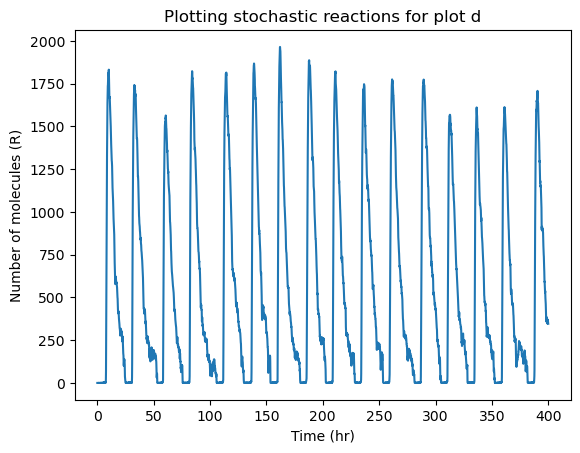

In [9]:
#plot d
start = time.time()
t, Y = SSA(prop, stoch(), X0, tspan, coeff, step = 0.1)
end = time.time()
time_plotd = (f'The time it took for the stochastic plot d  is {end-start}s')
print(time_plotd)
plt.plot(t, Y[:,5], label="R")
plt.title('Plotting stochastic reactions for plot d')
plt.xlabel('Time (hr)')
plt.ylabel('Number of molecules (R)')

In plot c and d, we can observe the stochatsic model generated for activator protein A seen in plot c and repressor protein R seen in plot d. The solution when we ran ODE showed supressor and activator protein relationship where repressor molecules peaked when activator molecules were flat. This makes sense as the repressor molecules are repressing all molecule activity. In this case here we can see that the repressor molecules having larger peaks expanded over time making the activator molecules peaks slimmer and active in smaller or shorter time durations. So stochastic model agrees to some extent with the deterministic model but not fully. Since in the stochastic model here has some randomness introduced it has caused the uneven peaks making the relationship between repressor and activator molecules slightly different. 

1b) For 1b parameters and coefficents are changed due to the change of delta_R per figure 5 description. The change was applied for both the ODE and the stochastic model. 

The time it took for the time explicit method RK45 for determinisitc plot a in figure 5 is 34.23176908493042s


Text(0, 0.5, 'Number of repressor molecules')

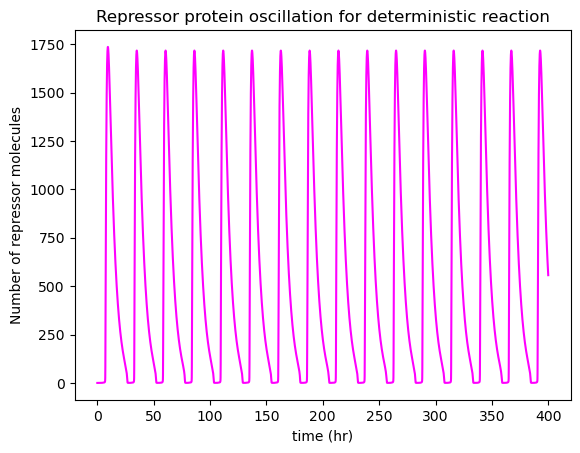

In [12]:

parameters["delta_R"] = 0.05
#Initial conditions values

initial_conditions = [1,1,0,0,0,0,0,0,0]  

#Calculations 
def rhs_circadian(t,y):
    
    alpha_A = parameters['Transcription_rates']['alpha_A']
    alpha_R = parameters['Transcription_rates']['alpha_R']
    alpha_prime_A = parameters['Transcription_rates']['alpha_prime_A']
    alpha_prime_R = parameters['Transcription_rates']['alpha_prime_R']
    
    delta_MA = parameters['Degradation_rates']['delta_MA']    
    delta_MR = parameters['Degradation_rates']['delta_MR']
    delta_A = parameters['Degradation_rates']['delta_A']
    delta_R = parameters['Degradation_rates']['delta_R']

    gamma_A = parameters['Binding_rates']['gamma_A']
    gamma_R = parameters['Binding_rates']['gamma_R']
    gamma_C = parameters['Binding_rates']['gamma_C']

    theta_A = parameters['Unbinding_rates']['theta_A']
    theta_R = parameters['Unbinding_rates']['theta_R']

    beta_A = parameters['Translation_rates']['beta_A']
    beta_R = parameters['Translation_rates']['beta_R']

    
    DA, DR, D_prime_A, D_prime_R, MA, MR, A, R, C = y

    #Equations
    dDA_dt = theta_A*D_prime_A - gamma_A*DA*A 
    dDR_dt = theta_R*D_prime_R - gamma_R*DR*A 
    dDprimeA_dt = gamma_A*DA*A - theta_A*D_prime_A 
    dDprimeR_dt = gamma_R*DR*A - theta_R*D_prime_R 
    dMA_dt = alpha_prime_A*D_prime_A + alpha_A*DA - delta_MA*MA 
    dA_dt = beta_A*MA + theta_A*D_prime_A + theta_R*D_prime_R - A*(gamma_A*DA + gamma_R*DR+ gamma_C*R + delta_A) 
    dMR_dt = alpha_prime_R*D_prime_R + alpha_R*DR - delta_MR*MR
    dR_dt = beta_R*MR - gamma_C*A*R + delta_A*C - delta_R*R
    dC_dt = gamma_C*A*R - delta_A*C
    return dDA_dt, dDR_dt, dDprimeA_dt, dDprimeR_dt, dMA_dt, dMR_dt, dA_dt, dR_dt, dC_dt

#ODE with time explicit RK45
tspan = [0, 400] #Limits time span in hours
start = time.time()
sol = solve_ivp(rhs_circadian, tspan, initial_conditions, method = 'RK45')
end = time.time()
time_RK45 = (f'The time it took for the time explicit method RK45 for determinisitc plot a in figure 5 is {end-start}s')
print(time_RK45)

plt.plot(sol.t, sol.y[-2], color='magenta')
plt.title('Repressor protein oscillation for deterministic reaction')
plt.xlabel('time (hr)')
plt.ylabel('Number of repressor molecules')

In [13]:
def prop(X,coeff):
    DA,D_prime_A, DR, D_prime_R, A, R, MA, MR, C = X
    theta_A, gamma_A, theta_R, gamma_R, delta_MA, delta_A, gamma_C, delta_MR, delta_R, alpha_prime_A, alpha_A, beta_A, alpha_prime_R, alpha_R, beta_R = coeff
    return [theta_A*D_prime_A, 
    gamma_A*DA*A, 
    theta_R*D_prime_R, 
    gamma_R*DR*A, 
    delta_MA*MA, 
    delta_A*A, 
    gamma_C*A*R,
    delta_MR*MR, 
    delta_R*R, 
    delta_A*C,
    alpha_prime_A*D_prime_A,
    alpha_A*DA,
    beta_A*MA,
    theta_A*D_prime_A, 
    theta_R*D_prime_R, 
    alpha_prime_R*D_prime_R,
    alpha_R*DR,
    beta_R*MR]
    
    
def stoch(): return np.array([[1,-1,0,0,0,0,0,0,0], #1
                      [-1,1,0,0,-1,0,0,0,0], #2
                      [0,0,1,-1,0,0,0,0,0], #3
                      [0,0,-1,1,-1,0,0,0,0], #4
                      [0,0,0,0,0,0,-1,0,0], #5
                      [0,0,0,0,-1,0,0,0,0], #6
                      [0,0,0,0,-1,-1,0,0,1], #7
                      [0,0,0,0,0,0,0,-1,0], #8
                      [0,0,0,0,0,-1,0,0,0], #9
                      [0,0,0,0,0,1,0,0,-1], #10
                      [0,0,0,0,0,0,1,0,0], #11
                      [0,0,0,0,0,0,1,0,0], #12
                      [0,0,0,0,1,0,0,0,0], #13
                      [0,0,0,0,1,0,0,0,0],  #14
                      [0,0,0,0,1,0,0,0,0], #15
                      [0,0,0,0,0,0,0,1,0], #16
                      [0,0,0,0,0,0,0,1,0], #17
                      [0,0,0,0,0,1,0,0,0]]) #18
    
coeff = [theta_A, gamma_A, theta_R, gamma_R, delta_MA, delta_A, gamma_C, delta_MR, delta_R, alpha_prime_A, alpha_A, beta_A, alpha_prime_R, alpha_R, beta_R]
coeff = np.array([50, 1, 100, 1, 10, 1, 2, 0.5, 0.05, 500, 50, 50, 50, 0.01, 5])

#Time intervall
tspan = [0, 400]  # Time interval duration

# Initial condition values
X0 = np.array([1,0,1,0,0,0,0,0,0])  

The time it took for plotting stochastic reaction in figure 5 for plot b is  30.421918869018555s


Text(0, 0.5, 'Number of repressor molecules')

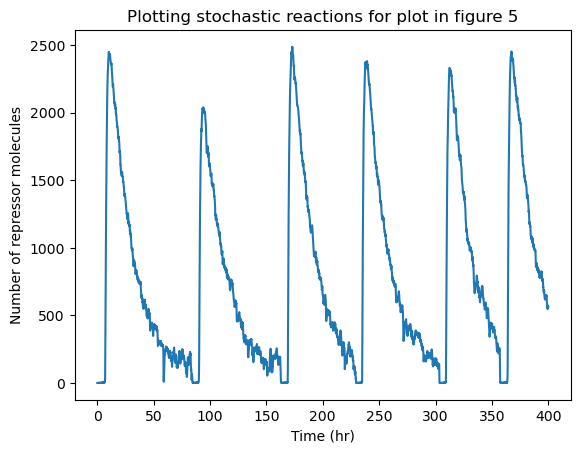

In [14]:
#plot c
start = time.time() 
t, Y = SSA(prop, stoch(), X0, tspan, coeff, step=0.1 )
end = time.time()
time_plot_b = (f'The time it took for plotting stochastic reaction in figure 5 for plot b is  {end-start}s')
print(time_plot_b)
plt.plot(t, Y[:,5], label="R")
plt.title('Plotting stochastic reactions for plot in figure 5')
plt.xlabel('Time (hr)')
plt.ylabel('Number of repressor molecules')

For plot a and b the delta_R reaction rate was changed to 0.05 from 0.2 per the  description seen under figure 5 in the paper. The differences can be seen when the repressor molecules are starting to reduce. We can see in the deterministic model in plot a that the represser smoothly regresses to 0 throughout the time intervall of 400 hours. Since it is a deterministic figure it shows that this is the outcome based on the slightest change of delta_R.  However, in plot b we can see that the repressor peaks at an equal pace distributed over the time intervall of 400 hours. The peaks can also be observed as more fuzzy which I asssume is due to the stochastic nature of the plot as randomness is introduced. Another observation is in the deterministic model there is only one peak while for the stochastic model there are peaks throghout the time intervall. This could be due to the change of reaction rate of delta_R in combination of introducing the randomness due to the stochastic model seen in plot b. Since the model oscillates and is sensitive to the slightest change the determinitic model will not oscillate properly, however the stochastic model due to randomness introduced will continue as in its nature randomness is applied so the slightest change might not be as effective comapred to the deterministic one. 